In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import os

%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

# HTuning 

In [4]:
htuning = pd.read_csv('./presentation/experiments/astromer_0/wandb_tables/htuning.csv')

In [5]:
table_croped = htuning[['dff', 'dropout_rate', 'head_dim', 
                        'learning_rate', 'n_heads', 'n_layers', 'epoch/val_loss', 'epoch/val_r_square']].dropna()
table_croped = table_croped.sort_values('epoch/val_loss')

In [6]:
table_croped.iloc[0]

dff                   64.000000
dropout_rate           0.395531
head_dim              64.000000
learning_rate          0.000010
n_heads                4.000000
n_layers               1.000000
epoch/val_loss         0.081091
epoch/val_r_square     0.712338
Name: 0, dtype: float64

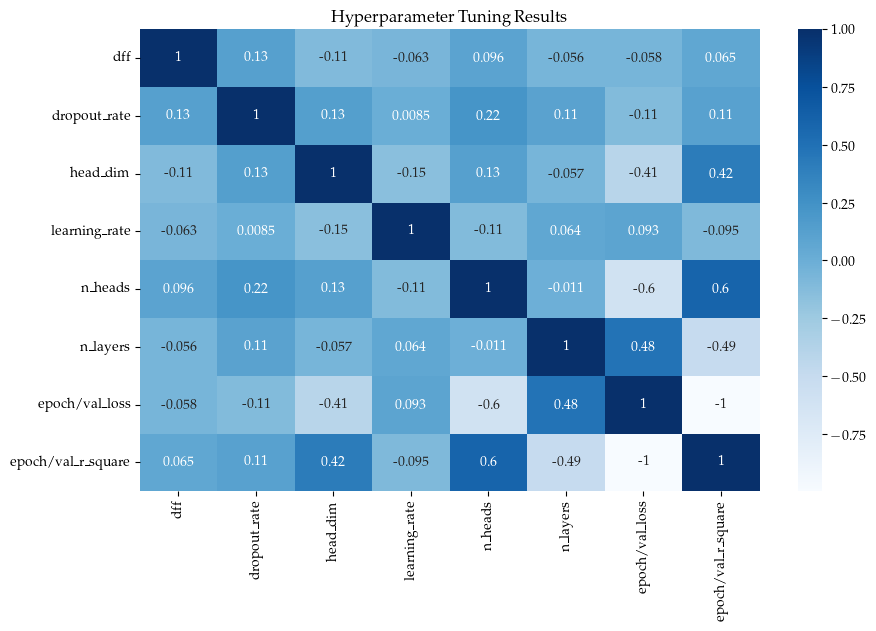

In [7]:
corr = table_croped.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Hyperparameter Tuning Results")
plt.show()

# Window size & Masking Percentage (Downstream)

In [8]:
downstream = pd.read_csv('presentation/experiments/astromer_0/wandb_tables/downstream.csv')
downstream.columns

Index(['Name', 'State', 'Notes', 'User', 'Tags', 'Created', 'Runtime', 'Sweep',
       'clf_name', 'dataset_to_ft', 'dff', 'dropout_rate', 'fold', 'head_dim',
       'learning_rate', 'n_heads', 'n_layers', 'paths', 'rand', 'clf',
       'epoch/accuracy', 'epoch/epoch', 'epoch/learning_rate', 'epoch/loss',
       'epoch/r_square', 'epoch/val_accuracy', 'epoch/val_loss',
       'epoch/val_r_square', 'ft_dataset', 'probed', 'window_size', 'test_f1',
       'test_precision', 'test_recall'],
      dtype='object')

In [9]:
masking = downstream[downstream['paths'].str.contains('masking')]
masking = masking[masking['clf_name'] == 'mlp_att']

In [10]:
summary_masking = masking[['dataset_to_ft','fold','probed', 'epoch/val_accuracy']].groupby(['dataset_to_ft', 'probed']).mean().reset_index()

In [16]:
paper_logs = './presentation/experiments/astromer_0/results_old/macho_mask_50_LR1e-05/'

ft_names = ['MACHO', 'ATLAS']

Text(-0.03, 0.5, 'Validation Accuracy')

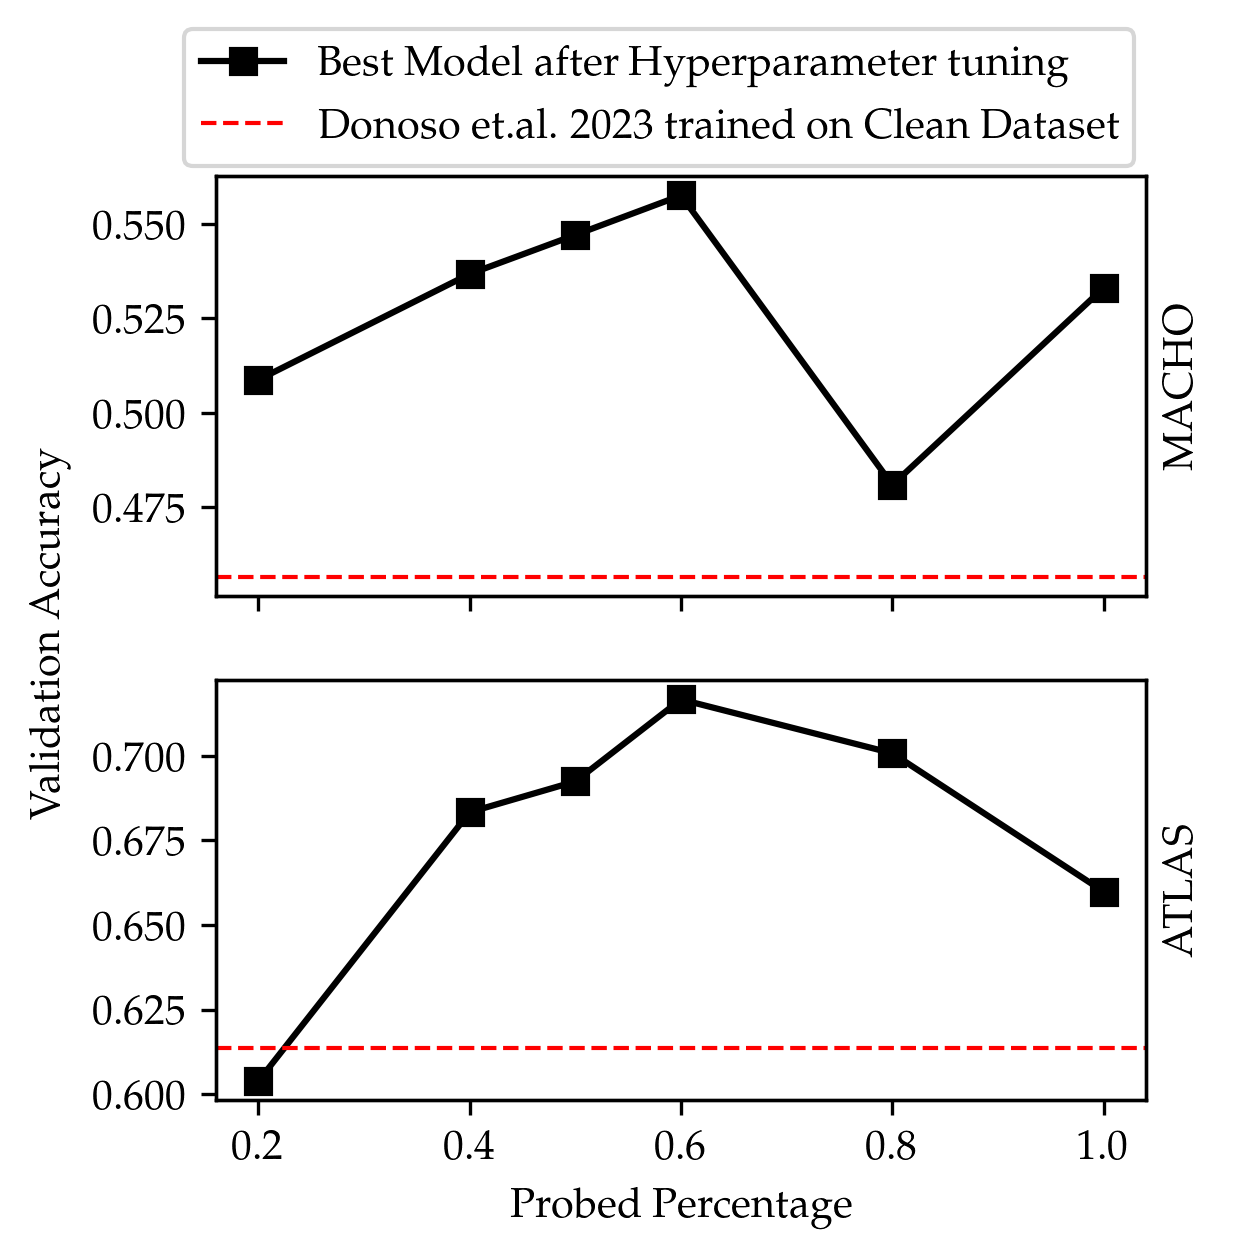

In [18]:
fig, axes = plt.subplots(2, 1, dpi=300, figsize=(4,4), sharex=True)

for k, ds in enumerate(['alcock', 'atlas']):
    
    # ===== paper results ====
    paper_metrics = pd.read_csv(os.path.join(paper_logs, ds, 'classification','metrics.csv'))
    paper_acc = paper_metrics[(paper_metrics['model'] == 'mlp_att') & \
                              (paper_metrics['spc'] == 20) & \
                              (paper_metrics['sci_case'] == 'a')]['val_acc'].mean()
    partial = summary_masking[summary_masking['dataset_to_ft'] == ds]
    axes[k].plot(partial['probed'], partial['epoch/val_accuracy'], marker='s', 
                 label='Best Model after Hyperparameter tuning', color='k')
    axes[k].axhline(y=paper_acc, color='red', linestyle='--', linewidth=1, label='Donoso et.al. 2023 trained on Clean Dataset')

    ax2 =  axes[k].twinx()     
    ax2.set_yticks([])
    ax2.set_ylabel(ft_names[k])
            
axes[0].legend(bbox_to_anchor = (1.01, 1.4), ncols=1)
axes[-1].set_xlabel('Probed Percentage')
fig.text(-0.03, 0.5, 'Validation Accuracy', va='center', rotation='vertical')

In [19]:
winsize = downstream[downstream['paths'].str.contains('winsize')]
winsize = winsize[winsize['clf_name'] == 'mlp_att']

In [20]:
summary_winsize = winsize[['dataset_to_ft','fold','window_size', 'epoch/val_accuracy']].groupby(['dataset_to_ft', 'window_size']).mean().reset_index()

Text(-0.01, 0.5, 'Validation Accuracy')

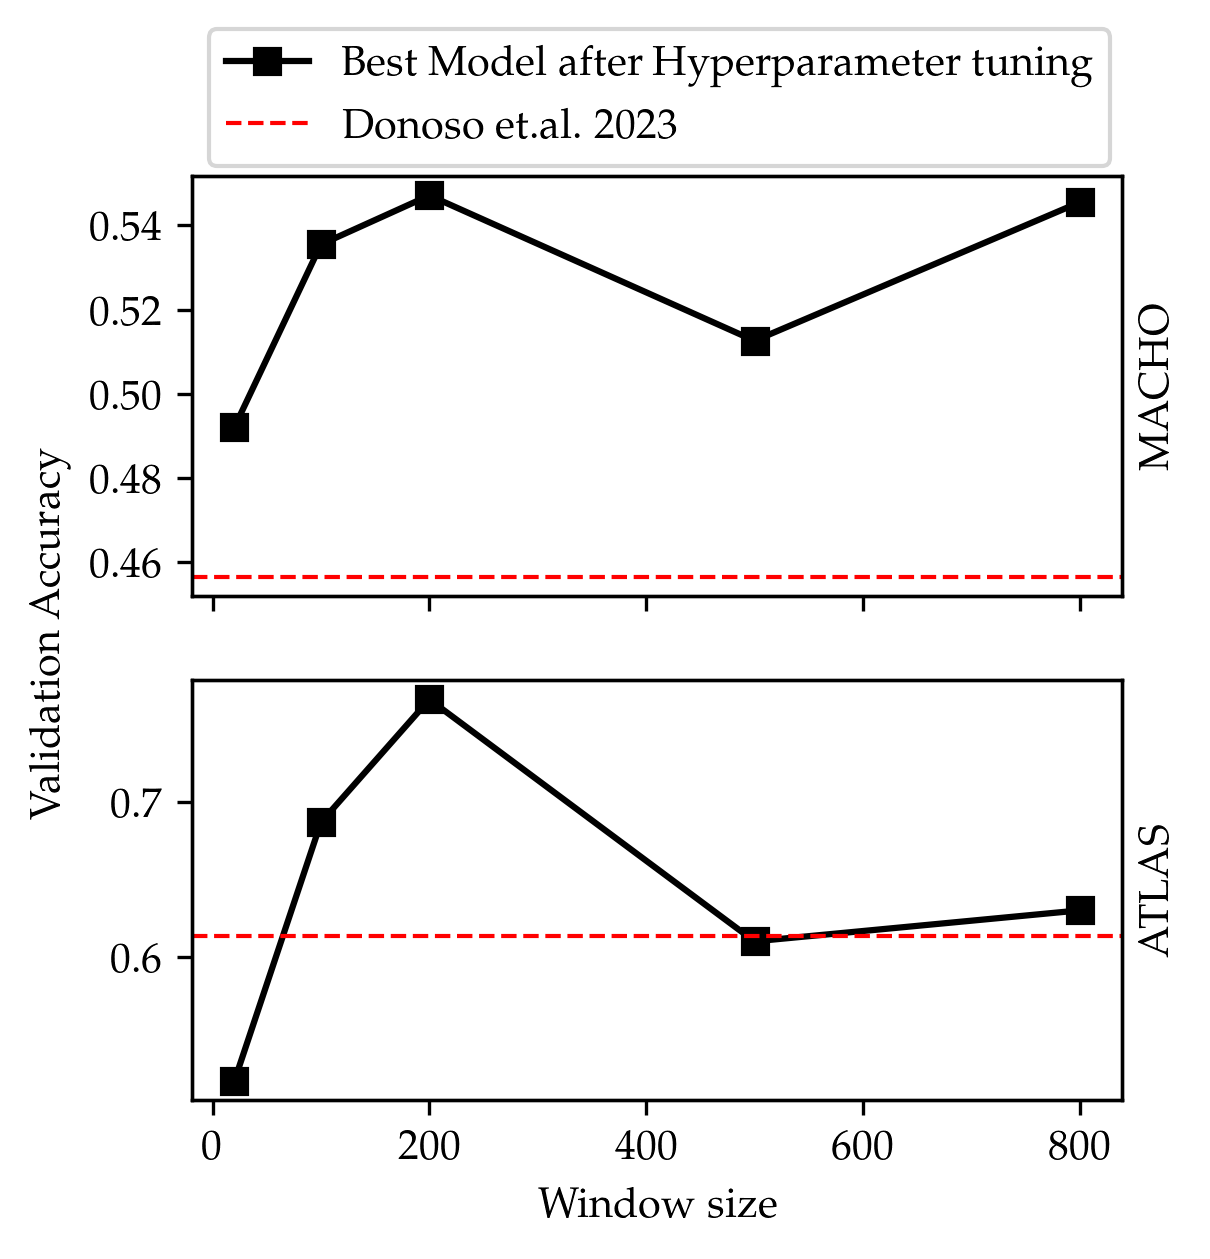

In [21]:
fig, axes = plt.subplots(2, 1, dpi=300, figsize=(4,4), sharex=True)

for k, ds in enumerate(['alcock', 'atlas']):
    
    # ===== paper results ====
    paper_metrics = pd.read_csv(os.path.join(paper_logs, ds, 'classification','metrics.csv'))
    paper_acc = paper_metrics[(paper_metrics['model'] == 'mlp_att') & \
                              (paper_metrics['spc'] == 20) & \
                              (paper_metrics['sci_case'] == 'a')]['val_acc'].mean()
    partial = summary_winsize[summary_winsize['dataset_to_ft'] == ds]
    axes[k].plot(partial['window_size'], partial['epoch/val_accuracy'], marker='s', 
                 label='Best Model after Hyperparameter tuning', color='k')
    axes[k].axhline(y=paper_acc, color='red', linestyle='--', linewidth=1, label='Donoso et.al. 2023')
    ax2 =  axes[k].twinx()     
    ax2.set_yticks([])
    ax2.set_ylabel(ft_names[k])
axes[0].legend(bbox_to_anchor = (1.01, 1.4), ncols=1)
axes[-1].set_xlabel('Window size')
fig.text(-0.01, 0.5, 'Validation Accuracy', va='center', rotation='vertical')